In [28]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


In [12]:
# read data from Data+_2025/data/enrollment_projections/sgr_table_region_2324_20240710.xlsx in Google Drive
sgr_data = pd.read_csv(r'C:\Users\kevan\OneDrive\Desktop\Data+\SGR_Region.csv')

In [13]:
# remove null values and shorten to only use relevant columns
sgr_data = sgr_data.dropna()
sgr_data.rename(columns={'sgr_dps_2324_all.1': 'sgr_dps_avg_k12'}, inplace=True) # because there might be a typo in the file?
sgr_data = sgr_data[['housing_type','region','sgr_dps_avg_k12']]
sgr_data['sgr_dps_avg_k12'] = sgr_data['sgr_dps_avg_k12'].round(4)
sgr_data.set_index(['region', 'housing_type'], inplace=True)

In [14]:
# read in shapefile to get geometries for HS regions from Data+_2025/QGIS/DPS shapefiles from layers in Google Drive
regions = gpd.read_file(r'C:\Users\kevan\OneDrive\Desktop\Data+\regions_2025_26\regions_2025_26.shp')[['region', 'geometry']]
regions = regions.to_crs('EPSG:4326')
#read in geojson with residential developments
res_dev = gpd.read_file(r'C:\Users\kevan\OneDrive\Desktop\Data+\DPS-Planning\resdev_cases.geojson')
res_dev = res_dev.to_crs('EPSG:4326')

In [15]:
def count_students(row):
        
    htype_map = {
        'sf_detached': 'sf_detach',
        'sf_attached': 'sf_attach',
        'duplex/triplex': 'du_tri',
        'multifamily': 'mf_apt',
        'condo': 'condo'
    }

    region = row['region']

    total = 0
    for col_name, sgr_col in htype_map.items():
        count = row.get(col_name, 0)

        try:
            multiplier = sgr_data.loc[(region, sgr_col), 'sgr_dps_avg_k12']
        except KeyError:
            multiplier = 0

        total += count * multiplier

    return total

In [16]:
res_dev['student_gen'] = res_dev.apply(count_students, axis=1)

In [17]:
regions.head()

,region,geometry
0,Central,"POLYGON ((-78.88564 36.03413, -78.88385 36.031..."
1,East,"POLYGON ((-78.7402 36.02356, -78.74019 36.0235..."
2,North,"POLYGON ((-78.80489 36.08853, -78.80558 36.088..."
3,Southeast,"POLYGON ((-78.8663 35.96692, -78.86565 35.9659..."
4,Southwest,"POLYGON ((-78.96564 36.03354, -78.96287 36.030..."


In [18]:
print(sgr_data.columns)

Index(['sgr_dps_avg_k12'], dtype='object')


In [25]:
res_dev.tail(30)

,A_NUMBER,A_TYPE,A_DATE,A_STATUS,A_STATUS_D,A_PROJECT_,A_DESCRIPT,A_USER_ID,A_CASE_PLA,StatCode,...,Editor,match_results,sf_detached,sf_attached,duplex/triplex,multifamily,condo,region,geometry,student_gen
209,D1900326,PL_MINSP,2019-09-12,APP,2020-10-21,Moriah Multi- Family,"264 Unit apartment complex, with 7,150 Sf clu...",KIMRO,DCULTRA,APP,...,gisproc_sys,"[(264, None, 'apartment', None)]",0,0,0,264,0,Southwest,POINT (-78.99377 35.94702),49.4472
210,D2200386,PL_MINSP,2022-11-03,APP,2024-02-28,3851 Hope Valley Road,Duplexes and single family subdivision. 40 tot...,JESSICADO,ROBINSH,APP,...,gisproc_sys,[ ],0,0,0,0,0,Southwest,POINT (-78.94176 35.94068),0.0000
211,D2300062,PL_MINSP,2023-03-03,APP,2023-12-07,5202 Garrett Road,"6 townhouses with small parking lot, dog park,...",COLERE,COLERE,APP,...,gisproc_sys,"[(6, None, 'townhouse', None)]",0,6,0,0,0,Southwest,POINT (-78.96975 35.949),0.4584
212,D2300140,PL_MINSP,2023-05-22,APP,2024-06-30,2201 Cornwallis Land,"103,000 sq. ft. of multifamily residential bui...",TREYFI,TREYFI,APP,...,gisproc_sys,[ ],0,0,0,0,0,Southwest,POINT (-78.95909 35.9825),0.0000
213,D2400176,PL_MINSP,2024-08-13,UN_RE,2024-08-13,Fox Crossing II,320 apartment units with 4800 sq ft of commerc...,TREYFI,TREYFI,UN_RE,...,gisproc_sys,"[(320, None, 'apartment', 'units')]",0,0,0,320,0,East,POINT (-78.85227 35.97085),68.9280
214,D2400193,PL_MINSP,2024-08-27,APP,2025-01-31,Durham Summit,312 multi-family apartment units with surface ...,JESSICADO,PEYTONBL,APP,...,gisproc_sys,"[(312, None, 'multifamily', None)]",0,0,0,312,0,North,POINT (-78.9038 36.04651),110.5104
215,D2400201,PL_MINSP,2024-09-06,UN_RE,2024-09-06,Trinity Park Townhomes,20 townhomes with ADU's and a commercial parki...,FRANCISCOM,TREYFI,UN_RE,...,gisproc_sys,"[(20, None, 'townhouse', None)]",0,20,0,0,0,Central,POINT (-78.91059 36.00193),0.6600
216,D2400205,PL_MINSP,2024-09-11,APP,2025-04-30,Fayette Place Ph 1,252 affordable unit apartment complex.,COLERE,COLERE,APP,...,gisproc_sys,"[(252, None, 'apartment', None)]",0,0,0,252,0,Southeast,POINT (-78.89557 35.98388),33.2136
217,D2400211,PL_SSP_SM,2024-09-17,UN_RE,2025-03-21,High Good - 106 Watts,25 MF residential units with ground floor comm...,COLERE,COLERE,UN_RE,...,gisproc_sys,[ ],0,0,0,0,0,Central,POINT (-78.91085 36.00162),0.0000
218,D2000155,PL_MINSP,2020-07-07,APP,2021-03-19,4000 Danube Lane,"90 townhome units with associated parking, uti...",COLERE,COLERE,APP,...,gisproc_sys,"[(90, None, 'townhouse', 'units')]",0,90,0,0,0,North,POINT (-78.88739 36.04761),9.1080


In [20]:
region_gen = res_dev.groupby('region')['student_gen'].sum()
regions.set_index('region', inplace=True)
regions['student_gen'] = region_gen

In [ ]:
#regions.to_file('region_gen.geojson', driver='GeoJSON')

In [27]:
#res_dev.to_file('resdev_with_stu_proj.geojson', driver='GeoJSON')
res_dev["student_gen"].max()

243.7312

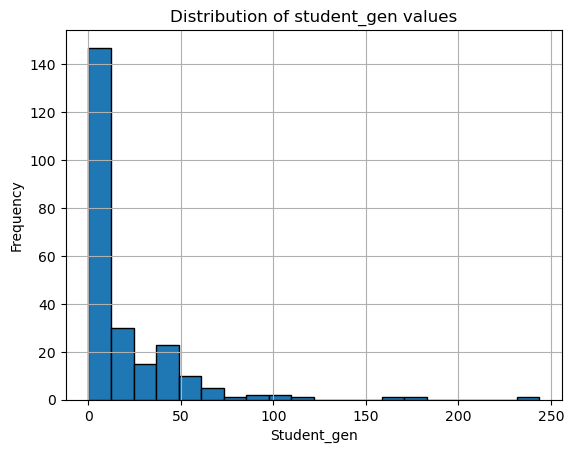

In [29]:
import matplotlib.pyplot as plt

# Plot histogram
res_dev["student_gen"].plot.hist(bins=20, edgecolor='black')

# Add labels and title
plt.xlabel("Student_gen")
plt.ylabel("Frequency")
plt.title("Distribution of student_gen values")
plt.grid(True)

plt.show()